Copyright by Arjun Sarkar Research Group Applied Systems Biology - Head: Prof. Dr. Marc Thilo Figge https://www.leibniz-hki.de/en/applied-systems-biology.html HKI-Center for Systems Biology of Infection Leibniz Institute for Natural Product Research and Infection Biology - Hans Knöll Insitute (HKI) Adolf-Reichwein-Straße 23, 07745 Jena, Germany

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import math
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
import datetime

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M, preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

from sklearn.model_selection import train_test_split

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

strategy = tf.distribute.MirroredStrategy(["GPU:0","GPU:1","GPU:2","GPU:3"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [3]:
df = pd.read_csv('Label_Patches_Training.csv')
df.head()

,video_num,filename,patch_name,infection,patient,class_label,image_path
0,1,246,246_0_0.tif,ca,1,0,/asbdata/Arjun/Bloodi/Patches/1/246_0_0.tif
1,1,246,246_0_1.tif,ca,1,0,/asbdata/Arjun/Bloodi/Patches/1/246_0_1.tif
2,1,246,246_1_0.tif,ca,1,0,/asbdata/Arjun/Bloodi/Patches/1/246_1_0.tif
3,1,246,246_1_1.tif,ca,1,0,/asbdata/Arjun/Bloodi/Patches/1/246_1_1.tif
4,1,94,094_0_0.tif,ca,1,0,/asbdata/Arjun/Bloodi/Patches/1/094_0_0.tif


In [4]:
image_size = 512
batch_size = 32

def get_test_and_valid_generator(test_df, x_col, y_cols, batch_size=batch_size, seed=1, image_size=image_size):

    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            target_size = (image_size,image_size),
            shuffle=False,
            seed=seed)
    
    return test_generator

In [5]:
def find_preds(array):
    
    list_preds = []
    preds = []
    
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
        
            preds = np.append(preds,array[i,j])
        
        preds = np.array(preds)
        
        unique, occ = np.unique(preds, return_counts=True)
        preds = []
        id_occ = np.argmax(occ)
        final_pred = unique[id_occ]
    
        list_preds = np.append(list_preds,final_pred)
        list_preds = np.array(list_preds)
        list_preds = list_preds.astype(int)
        
    return list_preds

In [6]:
def original_func(test):

    orig_labels_all = np.array(test['class_label'])
    orig_labels = np.reshape(orig_labels_all, (-1,1040))
    original_labels = find_preds(orig_labels)

    return original_labels, orig_labels_all

def predicted_func(model, test_generator):
    
    with strategy.scope():
        predicted_all = model.predict(test_generator, steps = len(test_generator)).argmax(axis=1)
        
    predicted_labels = np.reshape(predicted_all, (-1,1040))
    predicted_labels = find_preds(predicted_labels)
    
    return predicted_labels, predicted_all

In [7]:
with strategy.scope():

    final_model_1 = tf.keras.models.load_model('eff_patches_test_1.h5')
    final_model_2 = tf.keras.models.load_model('eff_patches_test_2.h5')
    final_model_3 = tf.keras.models.load_model('eff_patches_test_3.h5')
    final_model_4 = tf.keras.models.load_model('eff_patches_test_4.h5')
    final_model_5 = tf.keras.models.load_model('eff_patches_test_5.h5')
    final_model_6 = tf.keras.models.load_model('eff_patches_test_6.h5')
    final_model_7 = tf.keras.models.load_model('eff_patches_test_7.h5')
    final_model_8 = tf.keras.models.load_model('eff_patches_test_8.h5')
    final_model_9 = tf.keras.models.load_model('eff_patches_test_9.h5')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [8]:
target_names = ["$\it{C. albicans}$","$\it{C. glabrata}$","Mock"]

In [9]:
def confusion_matrix_(original_label,predicted_label,target_names, num):
    
    cm = confusion_matrix(original_label,predicted_label)
    # Normalise
    #sns.set(rc={"figure.dpi":200})
    cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,6))
    sns.set(font_scale = 1.5)
    image_cm = sns.heatmap(cm,cmap="flare",linewidths= 0.5,
            annot=True,xticklabels=target_names, yticklabels=target_names, cbar=0)
    plt.ylabel('True Labels', fontsize = 18)
    plt.xlabel('Predicted Labels', fontsize = 18)
    plt.xticks(rotation = 45, fontsize = 17)
    plt.yticks(rotation = 45,fontsize = 17)
    plt.title('Confusion Matrix', fontsize=20)
    plt.show(block=True)
    image_cm.figure.savefig('confusion_matrices_patches/Final_fullimage_'+str(num)+'.png',dpi=300,bbox_inches='tight')
    
def confusion_matrix_norm(original_label_all,predicted_label_all,target_names,num):
    
    cm = confusion_matrix(original_label_all,predicted_label_all)
    # Normalise
    #sns.set(rc={"figure.dpi":200})
    cmn = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    fig, ax = plt.subplots(figsize=(6,6))
    sns.set(font_scale = 1.5)
    image_cm=sns.heatmap(cmn, cmap="flare",linewidths= 0.5,
            annot=True,xticklabels=target_names, yticklabels=target_names, cbar=0)
    plt.ylabel('True Labels', fontsize = 18)
    plt.xlabel('Predicted Labels', fontsize = 18)
    plt.xticks(rotation = 45, fontsize = 17)
    plt.yticks(rotation = 45,fontsize = 17)
    plt.title('Confusion Matrix Normalized', fontsize=20)
    plt.show(block=True)
    image_cm.figure.savefig('confusion_matrices_patches/Normalized_fullimage_'+str(num)+'.png',dpi=300,bbox_inches='tight')
    
def confusion_matrix_all(original_label_all,predicted_label_all,target_names,num):
    
    cm = confusion_matrix(original_label_all,predicted_label_all)
    # Normalise
    #sns.set(rc={"figure.dpi":200})
    #cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,6))
    sns.set(font_scale = 1.5)
    image_cm = sns.heatmap(cm, cmap="flare",linewidths= 0.5,
            annot=True,fmt='g',xticklabels=target_names, yticklabels=target_names, cbar=0)
    plt.ylabel('True Labels', fontsize = 18)
    plt.xlabel('Predicted Labels', fontsize = 18)
    plt.xticks(rotation = 45, fontsize = 17)
    plt.yticks(rotation = 45,fontsize = 17)
    plt.title('Confusion Matrix All Patches', fontsize=20)
    plt.show(block=True)
    image_cm.figure.savefig('confusion_matrices_patches/All_fullimage_'+str(num)+'.png',dpi=300,bbox_inches='tight')

### Donor 1

In [10]:
test= df[df['patient']==1]
test.head()

test_generator= get_test_and_valid_generator(test, 'image_path','class_label')

original_label_1, original_label_all_1 = original_func(test)
predicted_label_1, predicted_label_all_1 = predicted_func(final_model_1, test_generator)

print(original_label_1)
print(original_label_all_1)
print(predicted_label_1)
print(predicted_label_all_1)

Found 3120 validated image filenames.
98/98 [==============================] - 49s 268ms/step
[0 1 2]
[0 0 0 ... 2 2 2]
[0 1 2]
[2 0 0 ... 2 2 2]


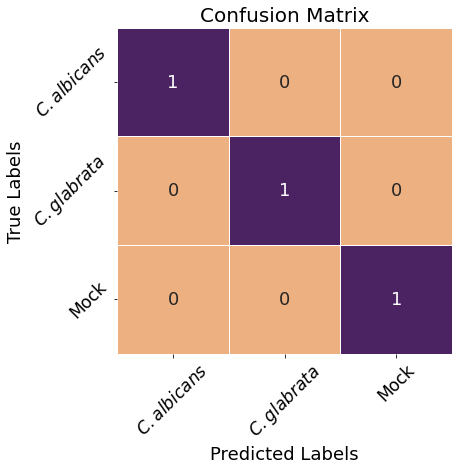

In [11]:
confusion_matrix_(original_label_1,predicted_label_1,target_names,1)

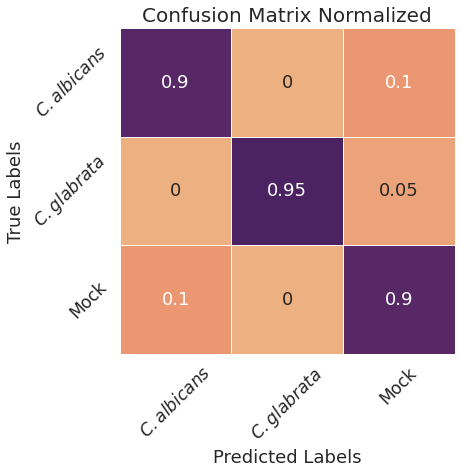

In [12]:
confusion_matrix_norm(original_label_all_1, predicted_label_all_1,target_names,1)

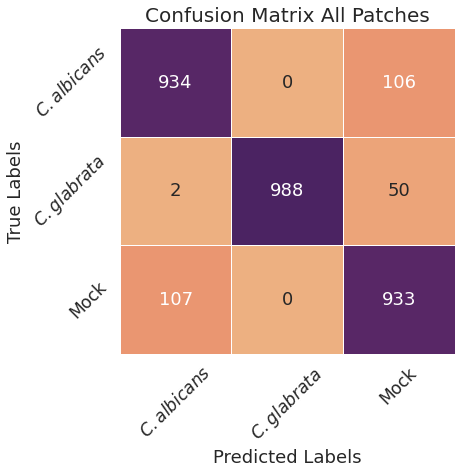

In [13]:
confusion_matrix_all(original_label_all_1,predicted_label_all_1,target_names,1)

### Donor 2

In [14]:
test= df[df['patient']==2]
test.head()

test_generator= get_test_and_valid_generator(test, 'image_path','class_label')

original_label_2, original_label_all_2 = original_func(test)
predicted_label_2, predicted_label_all_2 = predicted_func(final_model_2, test_generator)

print(original_label_2)
print(original_label_all_2)
print(predicted_label_2)
print(predicted_label_all_2)

Found 3120 validated image filenames.
98/98 [==============================] - 38s 242ms/step
[0 1 2]
[0 0 0 ... 2 2 2]
[0 1 2]
[0 0 0 ... 2 2 2]


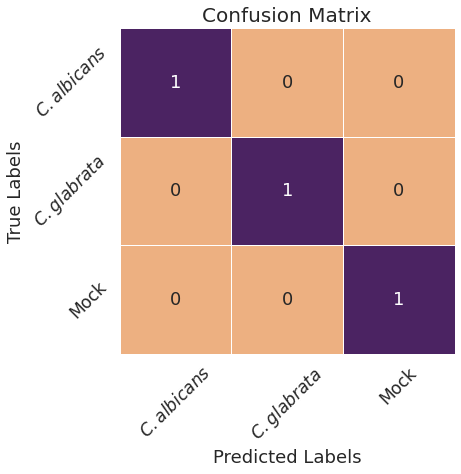

In [15]:
confusion_matrix_(original_label_2,predicted_label_2,target_names,2)

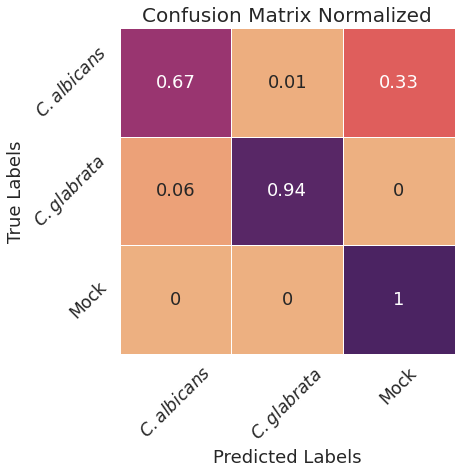

In [16]:
confusion_matrix_norm(original_label_all_2, predicted_label_all_2,target_names,2)

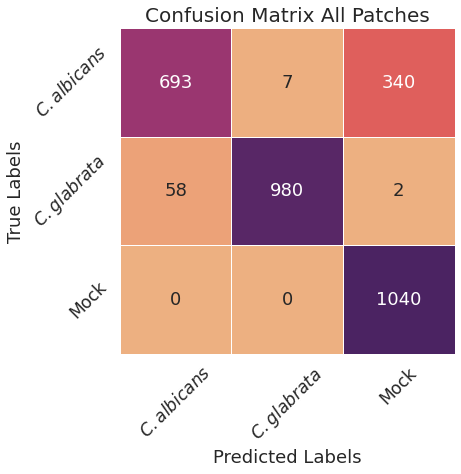

In [17]:
confusion_matrix_all(original_label_all_2,predicted_label_all_2,target_names,2)

### Donor 3

In [18]:
test= df[df['patient']==5]
test.head()

test_generator= get_test_and_valid_generator(test, 'image_path','class_label')

original_label_3, original_label_all_3 = original_func(test)
predicted_label_3, predicted_label_all_3 = predicted_func(final_model_3, test_generator)

print(original_label_3)
print(original_label_all_3)
print(predicted_label_3)
print(predicted_label_all_3)

Found 3120 validated image filenames.
98/98 [==============================] - 36s 230ms/step
[0 1 2]
[0 0 0 ... 2 2 2]
[0 1 2]
[0 0 0 ... 2 2 2]


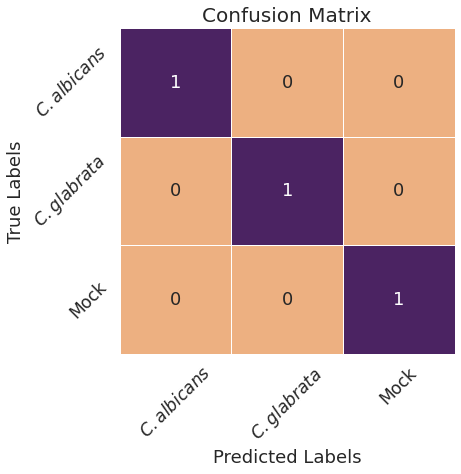

In [19]:
confusion_matrix_(original_label_3,predicted_label_3,target_names,3)

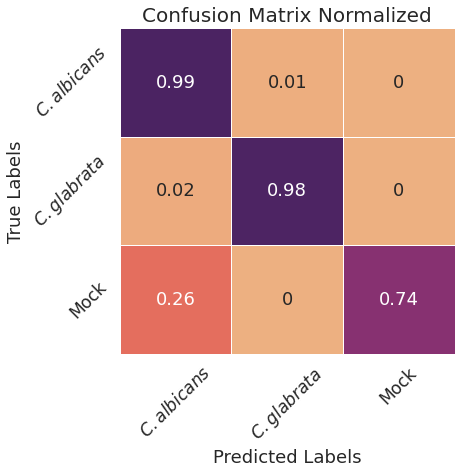

In [20]:
confusion_matrix_norm(original_label_all_3, predicted_label_all_3,target_names,3)

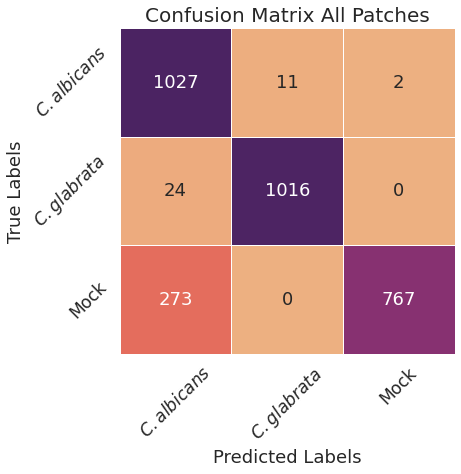

In [21]:
confusion_matrix_all(original_label_all_3,predicted_label_all_3,target_names,3)

### Donor 4

In [22]:
test= df[df['patient']==7]
test.head()

test_generator= get_test_and_valid_generator(test, 'image_path','class_label')

original_label_4, original_label_all_4 = original_func(test)
predicted_label_4, predicted_label_all_4 = predicted_func(final_model_4, test_generator)

print(original_label_4)
print(original_label_all_4)
print(predicted_label_4)
print(predicted_label_all_4)

Found 3120 validated image filenames.
98/98 [==============================] - 37s 227ms/step
[0 1 2]
[0 0 0 ... 2 2 2]
[0 1 2]
[0 0 0 ... 2 2 2]


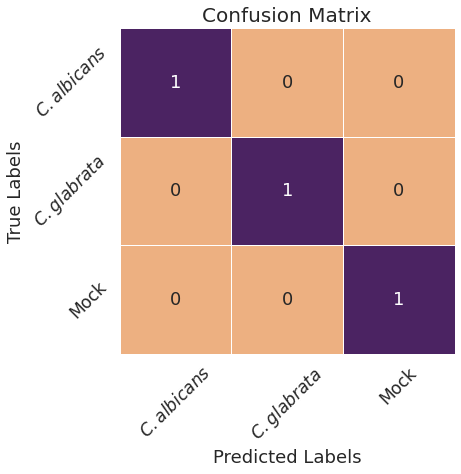

In [23]:
confusion_matrix_(original_label_4,predicted_label_4, target_names,4)

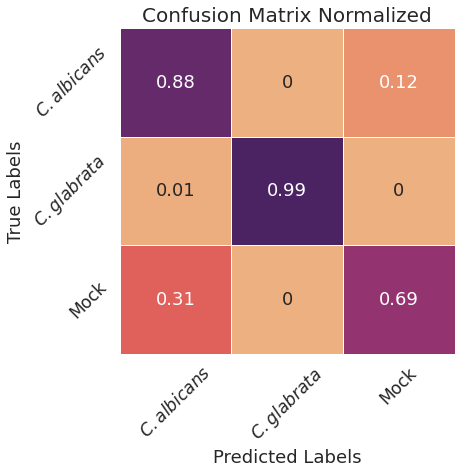

In [24]:
confusion_matrix_norm(original_label_all_4, predicted_label_all_4,target_names,4)

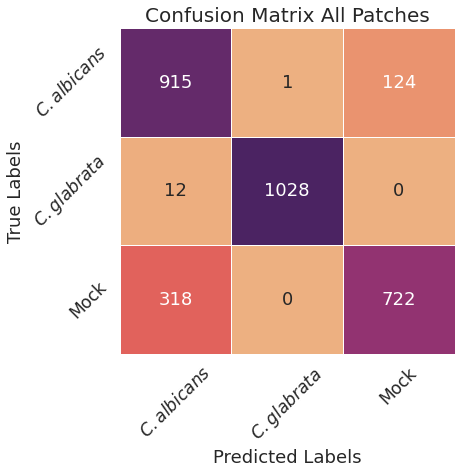

In [25]:
confusion_matrix_all(original_label_all_4,predicted_label_all_4,target_names,4)

### Donor 5

In [26]:
test= df[df['patient']==8]
test.head()

test_generator= get_test_and_valid_generator(test, 'image_path','class_label')

original_label_5, original_label_all_5 = original_func(test)
predicted_label_5, predicted_label_all_5 = predicted_func(final_model_5, test_generator)

print(original_label_5)
print(original_label_all_5)
print(predicted_label_5)
print(predicted_label_all_5)

Found 3120 validated image filenames.
98/98 [==============================] - 33s 208ms/step
[0 1 2]
[0 0 0 ... 2 2 2]
[0 1 2]
[0 0 0 ... 2 2 2]


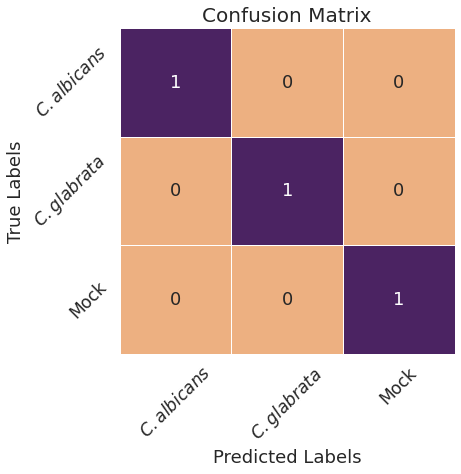

In [27]:
confusion_matrix_(original_label_5,predicted_label_5, target_names,5)

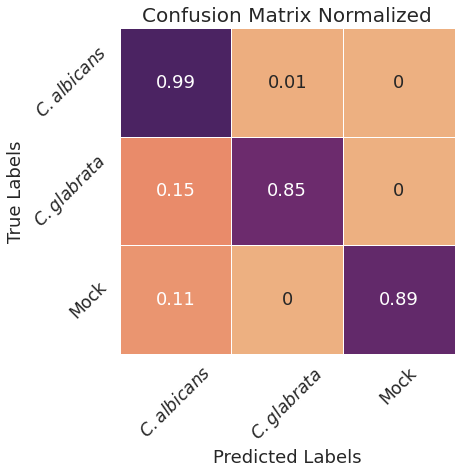

In [28]:
confusion_matrix_norm(original_label_all_5, predicted_label_all_5,target_names,5)

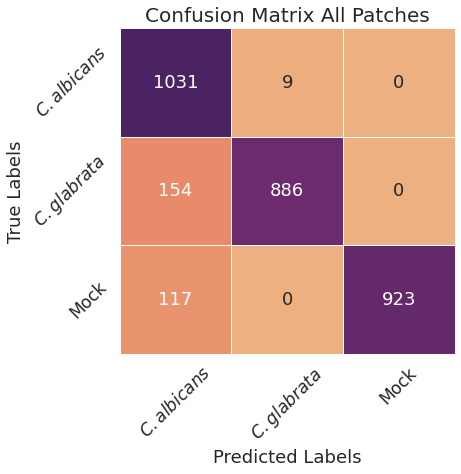

In [29]:
confusion_matrix_all(original_label_all_5,predicted_label_all_5,target_names,5)

### Donor 6

In [30]:
test= df[df['patient']==9]
test.head()

test_generator= get_test_and_valid_generator(test, 'image_path','class_label')

original_label_6, original_label_all_6 = original_func(test)
predicted_label_6, predicted_label_all_6 = predicted_func(final_model_6, test_generator)

print(original_label_6)
print(original_label_all_6)
print(predicted_label_6)
print(predicted_label_all_6)

Found 3120 validated image filenames.
98/98 [==============================] - 40s 270ms/step
[0 1 2]
[0 0 0 ... 2 2 2]
[0 1 2]
[0 0 1 ... 2 0 0]


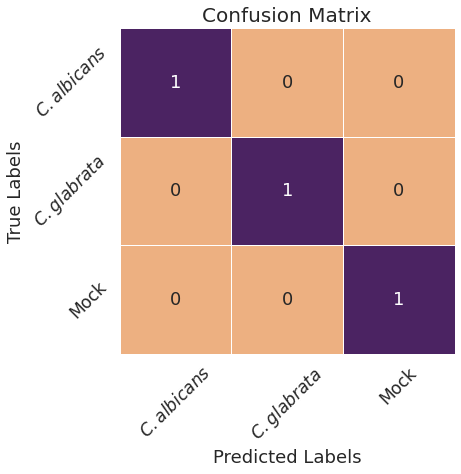

In [31]:
confusion_matrix_(original_label_6,predicted_label_6, target_names,6)

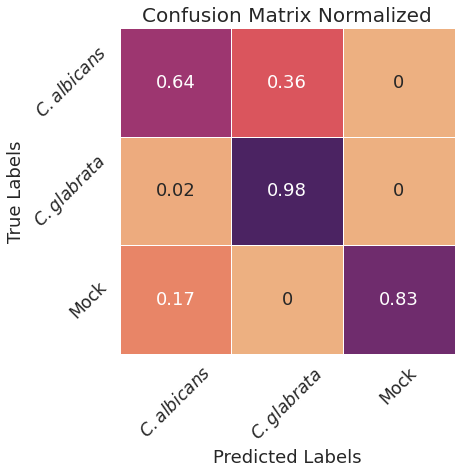

In [32]:
confusion_matrix_norm(original_label_all_6, predicted_label_all_6,target_names,6)

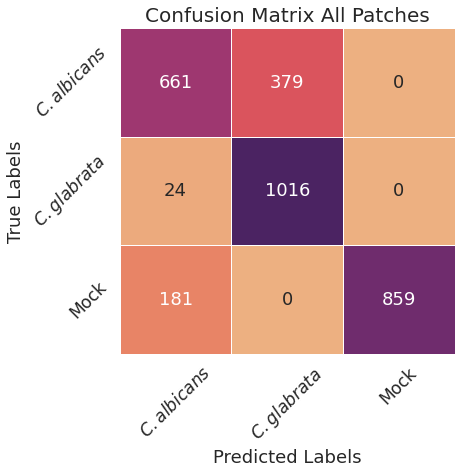

In [33]:
confusion_matrix_all(original_label_all_6,predicted_label_all_6,target_names,6)

### Donor 7

In [34]:
test= df[df['patient']==10]
test.head()

test_generator= get_test_and_valid_generator(test, 'image_path','class_label')

original_label_7, original_label_all_7 = original_func(test)
predicted_label_7, predicted_label_all_7 = predicted_func(final_model_7, test_generator)

print(original_label_7)
print(original_label_all_7)
print(predicted_label_7)
print(predicted_label_all_7)

Found 3120 validated image filenames.
98/98 [==============================] - 38s 248ms/step
[0 1 2]
[0 0 0 ... 2 2 2]
[0 1 2]
[0 0 0 ... 2 2 2]


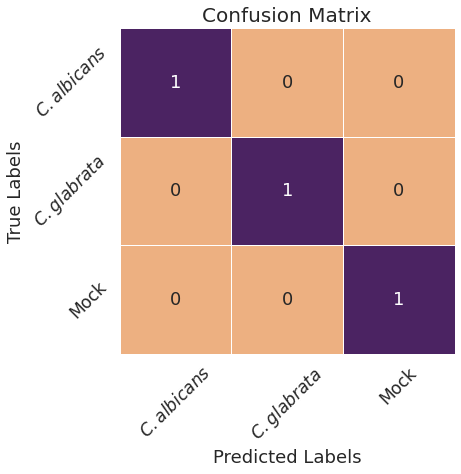

In [35]:
confusion_matrix_(original_label_7,predicted_label_7, target_names,7)

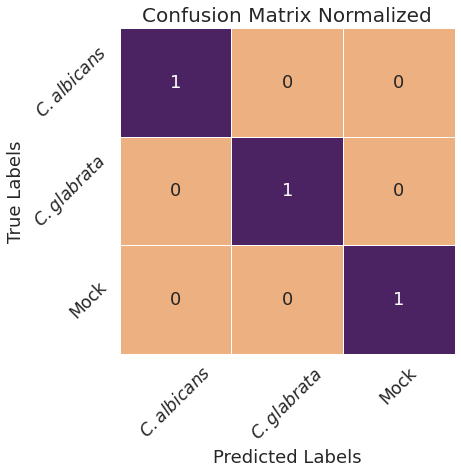

In [36]:
confusion_matrix_norm(original_label_all_7, predicted_label_all_7,target_names,7)

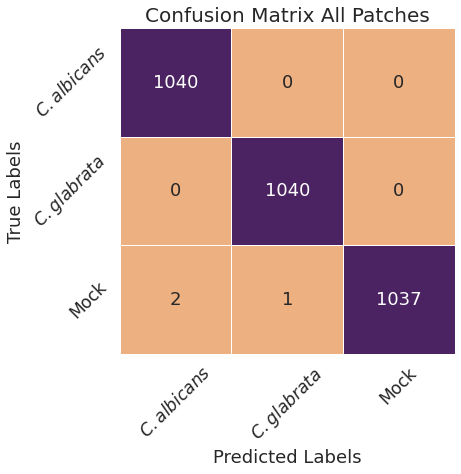

In [37]:
confusion_matrix_all(original_label_all_7,predicted_label_all_7,target_names,7)

### Donor 8

In [38]:
test= df[df['patient']==11]
test.head()

test_generator= get_test_and_valid_generator(test, 'image_path','class_label')

original_label_8, original_label_all_8 = original_func(test)
predicted_label_8, predicted_label_all_8 = predicted_func(final_model_8, test_generator)

print(original_label_8)
print(original_label_all_8)
print(predicted_label_8)
print(predicted_label_all_8)

Found 3120 validated image filenames.
98/98 [==============================] - 36s 243ms/step
[0 1 2]
[0 0 0 ... 2 2 2]
[0 1 2]
[0 0 0 ... 2 2 2]


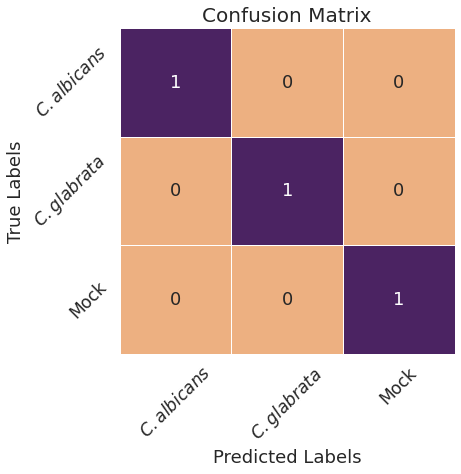

In [39]:
confusion_matrix_(original_label_8,predicted_label_8, target_names,8)

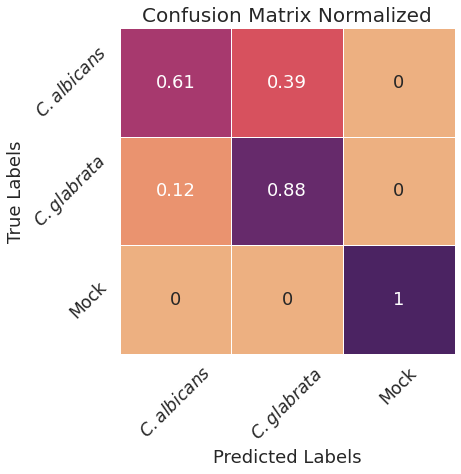

In [40]:
confusion_matrix_norm(original_label_all_8, predicted_label_all_8,target_names,8)

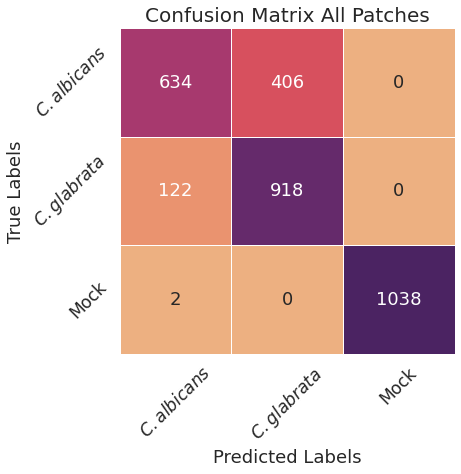

In [41]:
confusion_matrix_all(original_label_all_8,predicted_label_all_8,target_names,8)

### Donor 9

In [42]:
test= df[df['patient']==12]
test.head()

test_generator= get_test_and_valid_generator(test, 'image_path','class_label')

original_label_9, original_label_all_9 = original_func(test)
predicted_label_9, predicted_label_all_9 = predicted_func(final_model_9, test_generator)

print(original_label_9)
print(original_label_all_9)
print(predicted_label_9)
print(predicted_label_all_9)

Found 3120 validated image filenames.
98/98 [==============================] - 34s 201ms/step
[0 1 2]
[0 0 0 ... 2 2 2]
[0 1 2]
[0 0 2 ... 2 2 2]


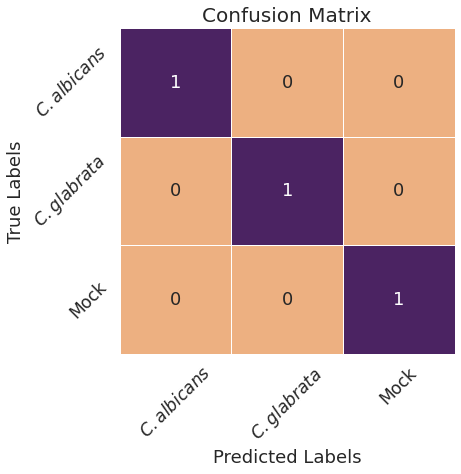

In [43]:
confusion_matrix_(original_label_9,predicted_label_9, target_names,9)

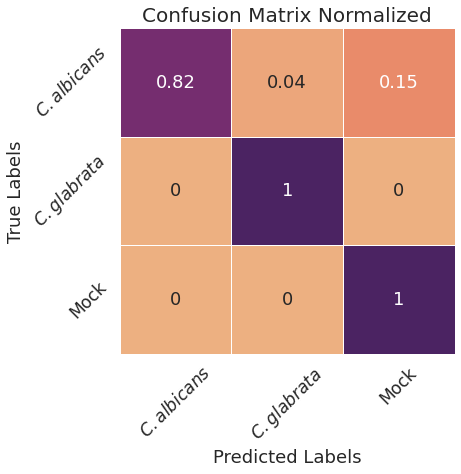

In [44]:
confusion_matrix_norm(original_label_all_9, predicted_label_all_9,target_names,9)

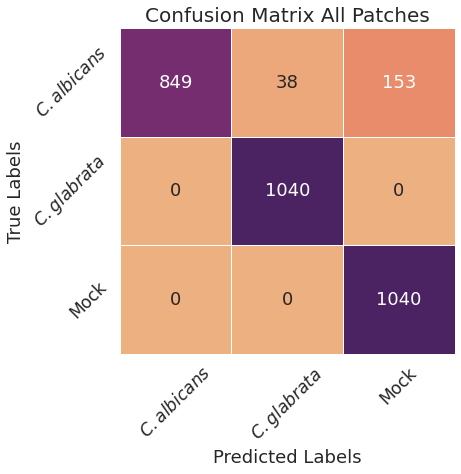

In [45]:
confusion_matrix_all(original_label_all_9,predicted_label_all_9,target_names,9)

### ALL Donors

In [46]:
donors = [1,2,3,4,5,6,7,8,9]

orig_labels = []

for i in donors:
    orig_labels.extend(eval('original_label_'+str(i)))
    
orig = np.array(orig_labels)
orig

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2])

In [47]:
pred_labels = []

for i in donors:
    pred_labels.extend(eval('predicted_label_'+str(i)))
    
pred = np.array(pred_labels)
pred

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2])

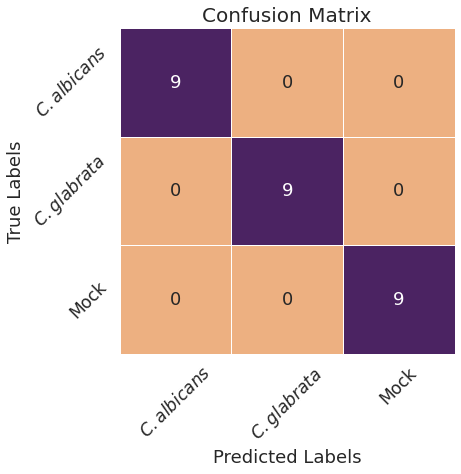

In [48]:
confusion_matrix_(orig, pred, target_names, 0)

In [49]:
orig_labels_all = []

for i in donors:
    orig_labels_all.extend(eval('original_label_all_'+str(i)))
    
orig_all = np.array(orig_labels_all)
orig_all

array([0, 0, 0, ..., 2, 2, 2])

In [50]:
pred_labels_all = []

for i in donors:
    pred_labels_all.extend(eval('predicted_label_all_'+str(i)))
    
pred_all = np.array(pred_labels_all)
pred_all

array([2, 0, 0, ..., 2, 2, 2])

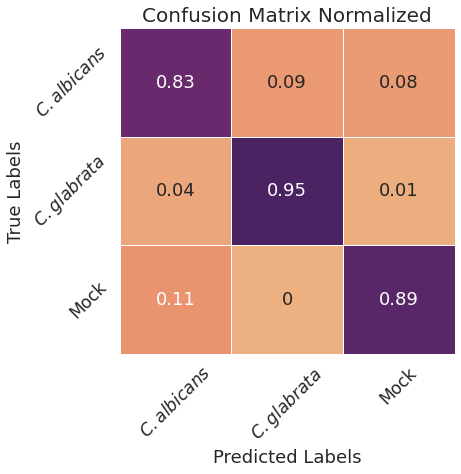

In [51]:
confusion_matrix_norm(orig_all, pred_all, target_names, 0)

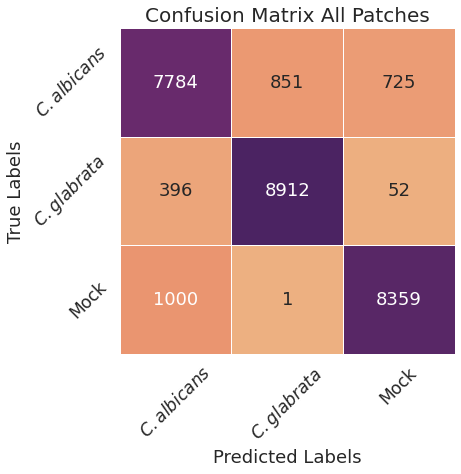

In [52]:
def confusion_matrix_all_donors(original_label_all,predicted_label_all,target_names,num):
    
    cm = confusion_matrix(original_label_all,predicted_label_all)
    # Normalise
    #sns.set(rc={"figure.dpi":200})
    #cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,6))
    sns.set(font_scale = 1.5)
    image_cm = sns.heatmap(cm, cmap="flare",linewidths= 0.5,
            annot=True,fmt='g',xticklabels=target_names, yticklabels=target_names, cbar=0)
    plt.ylabel('True Labels', fontsize = 18)
    plt.xlabel('Predicted Labels', fontsize = 18)
    plt.xticks(rotation = 45, fontsize = 17)
    plt.yticks(rotation = 45,fontsize = 17)
    plt.title('Confusion Matrix All Patches', fontsize=20)
    plt.show(block=True)
    image_cm.figure.savefig('confusion_matrices_patches/All_'+str(num)+'.png',dpi=300,bbox_inches='tight')


confusion_matrix_all_donors(orig_all,pred_all,target_names,0)